# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

In [243]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [245]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'

## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


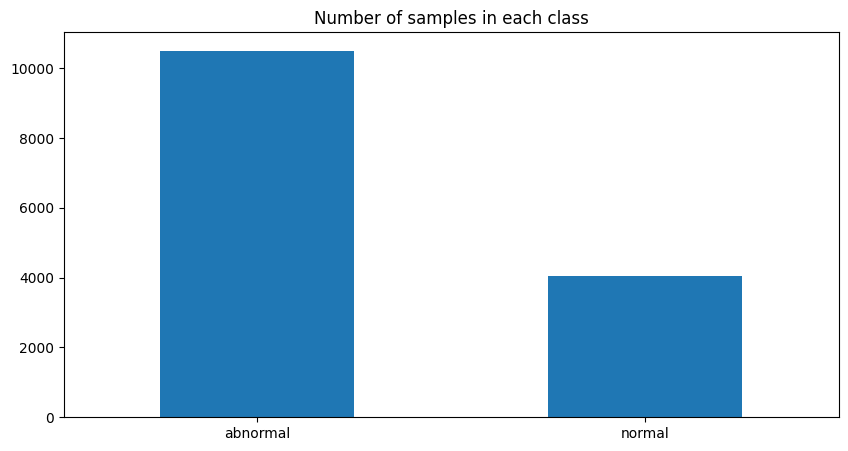

In [246]:
df_ptbd_normal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal",
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

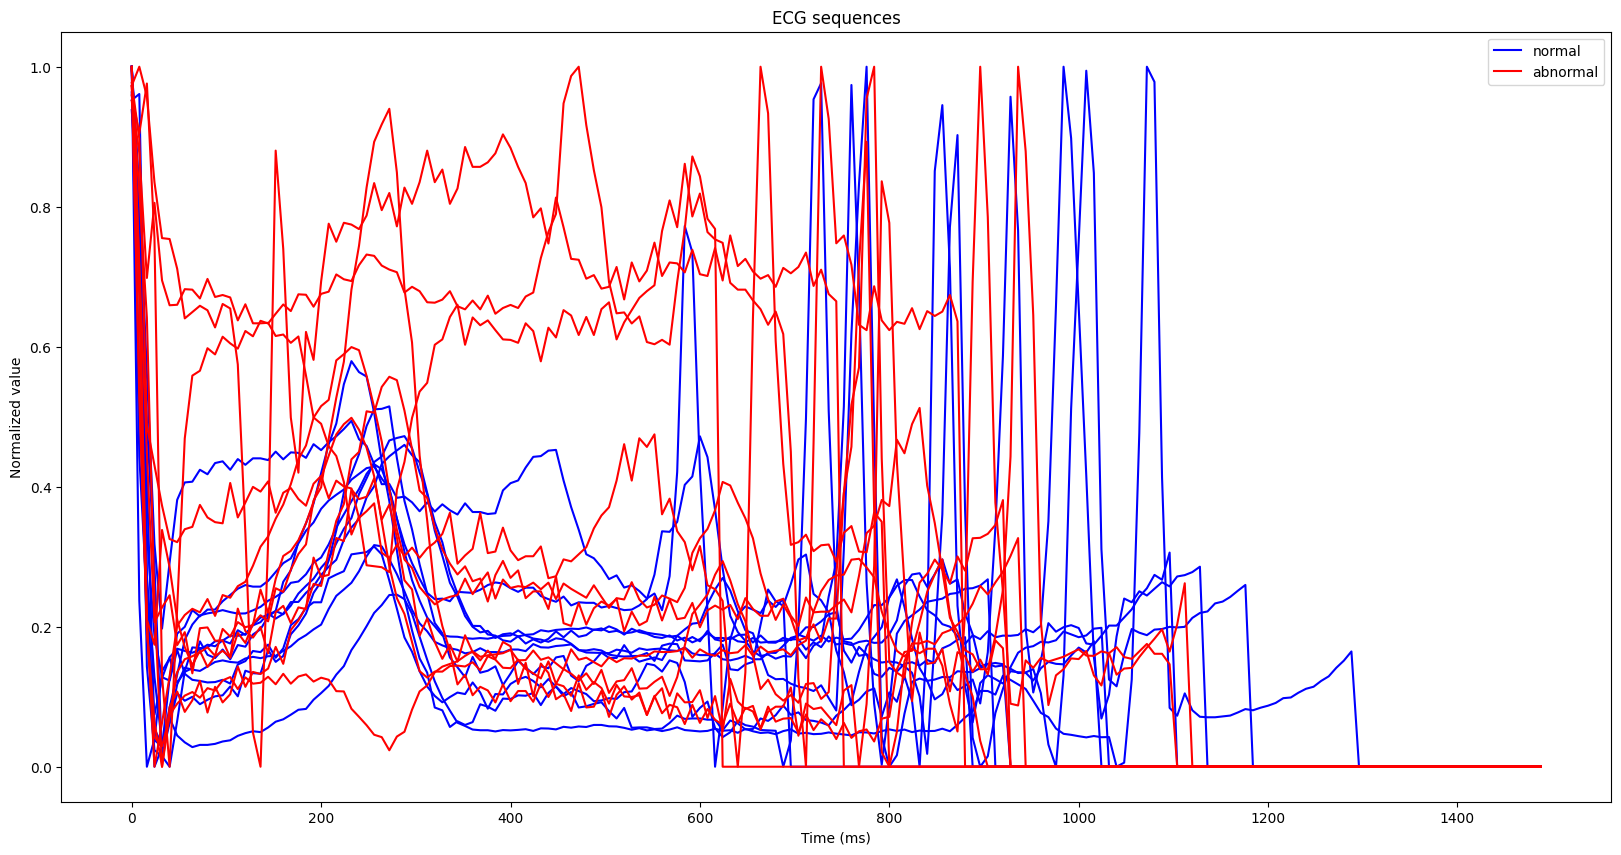

In [247]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [248]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [249]:
X = df_ptbd.iloc[:, :187].values
y = df_ptbd.iloc[:, 187].values

X = X.reshape(-1, 187)  # Reshape X to (-1, 187)
y = y.reshape(-1, 1)    # Reshape y to (-1, 1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [250]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()

        # self.conv1 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)

        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()

        # self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # out = self.conv1(x)
        out = self.fc1(x)
        out = self.relu(out)
        # out = self.pool1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Define the model parameters
input_dim = X.shape[1]
# hidden_dim = 64
output_dim = 1

# Create an instance of the model
model = NeuralNet(input_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [251]:
# Train the model
num_epochs = 30
batch_size = 32

In [252]:
for epoch in range(1, num_epochs+1):
    # Mini-batch training
    for i in range(0, X_train_tensor.size(0), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if(epoch%5==0):
      print(f"Epoch {epoch}")

Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30


In [253]:
# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs)
    accuracy = (predicted_labels == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print("Test Accuracy:", accuracy)

Test Accuracy: 0.9319821367227756


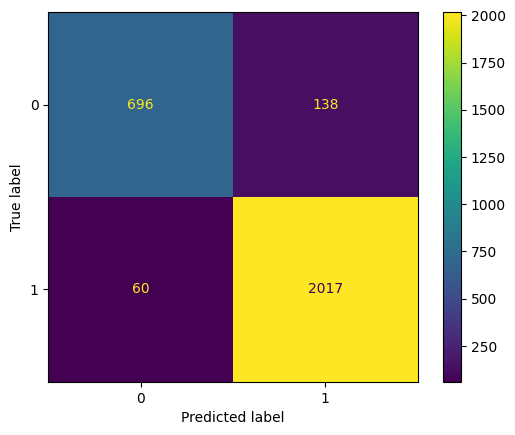

In [254]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test_tensor, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()